In [139]:
#Lets have matplotlib "inline"
%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

#Import packages we need
import numpy as np
from matplotlib import animation, rc
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import os
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
import datetime
import sys

#Set large figure sizes
#rc('figure', figsize=(16.0, 12.0))
#rc('animation', html='html5')
plt.rcParams["animation.html"] = "jshtml"

#Import our simulator
from gpuocean.SWEsimulators import FBL, CTCS, KP07, CDKLM16
from gpuocean.utils import PlotHelper, Common, IPythonMagic
#Import initial condition and bathymetry generating functions:
from gpuocean.utils.BathymetryAndICs import *

In [140]:
%cuda_context_handler gpu_ctx

In [141]:
# Set initial conditions common to all simulators
dt = 1
sim_args = {
"gpu_ctx": gpu_ctx,
"nx": 201, "ny": 201,
"dx": 100.0, "dy": 100.0,
"dt": dt,
"g": 9.81,
"f": 0.0,
"coriolis_beta": 0, #1.0e-6,
"r": 0.0
}

In [142]:
def TV(sim):
    eta, hu, hv = sim.download(interior_domain_only=True)
    dx = sim.dx
    dy = sim.dy
    tv_eta = tv_hu = tv_hv = 0.0
    tv_eta = dy*np.sum(np.abs(eta[:,1:] - eta[:,:-1])) + dx*np.sum(np.abs(eta[1:,:] - eta[:-1, :]))
    tv_hu  = dy*np.sum(np.abs( hu[:,1:] -  hu[:,:-1])) + dx*np.sum(np.abs( hu[1:,:] -  hu[:-1, :]))
    tv_hv  = dy*np.sum(np.abs( hv[:,1:] -  hv[:,:-1])) + dx*np.sum(np.abs( hv[1:,:] -  hv[:-1, :]))

    return tv_eta, tv_hu, tv_hv
    

In [143]:
def plotstate(eta, hu, hv, title, vmax=0.05):
    fig = plt.figure(figsize=(14,4))
    ax_eta = plt.subplot(1,3,1)
    sp_eta = ax_eta.imshow(eta, vmin=-0.001, vmax=0.001, origin='lower')
    plt.colorbar(sp_eta, ax= ax_eta, shrink=0.5)
    
    ax_u = plt.subplot(1,3,2)
    sp_u = ax_u.imshow(hu, vmin=-vmax, vmax=vmax, origin='lower')
    plt.colorbar(sp_u, ax= ax_u, shrink=0.5)
    
    ax_v = plt.subplot(1,3,3)
    sp_v = ax_v.imshow(hv, vmin=-vmax, vmax=vmax, origin='lower')
    plt.colorbar(sp_v, ax= ax_v, shrink=0.5)
    plt.suptitle(title)

In [144]:
from importlib import reload
reload(CDKLM16)

ghosts = np.array([2,2,2,2]) # north, east, south, west
dataShape = (sim_args["ny"] + ghosts[0]+ghosts[2], 
             sim_args["nx"] + ghosts[1]+ghosts[3])

H = np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32) * 60.0
eta0 = np.zeros(dataShape, dtype=np.float32)
u0 = np.zeros(dataShape, dtype=np.float32)
v0 = np.zeros(dataShape, dtype=np.float32)

midx = sim_args["nx"]//2 
midy = sim_args["ny"]//2 

eta0[midy+2,midx+2] = 0.1
#eta0[midy+2-4:midy+2+4, midx+2-4:midx+2+4] = 0.1

#Initialize simulator
fvm_args = {"H": H, "eta0": eta0, "hu0": u0, "hv0": v0 }
sim_cu = CDKLM16.CDKLM16(**fvm_args, **sim_args, 
                          central_upwind=False, flux_delimiter=0.0, rk_order= 2)
sim_su = CDKLM16.CDKLM16(**fvm_args, **sim_args, 
                          central_upwind=False, flux_delimiter=1.0, rk_order= 2)
#sim = KP07.KP07(**fvm_args, **sim_args, use_rk2=True)

#Run a simulation and plot it


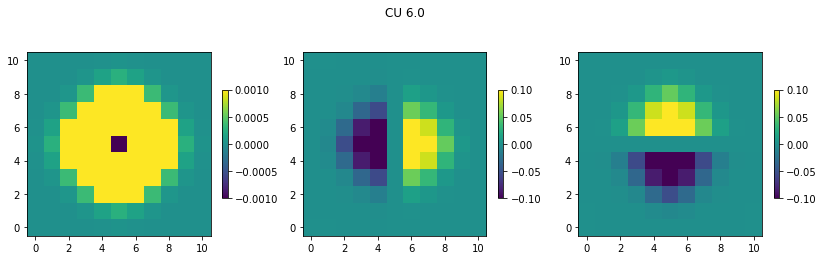

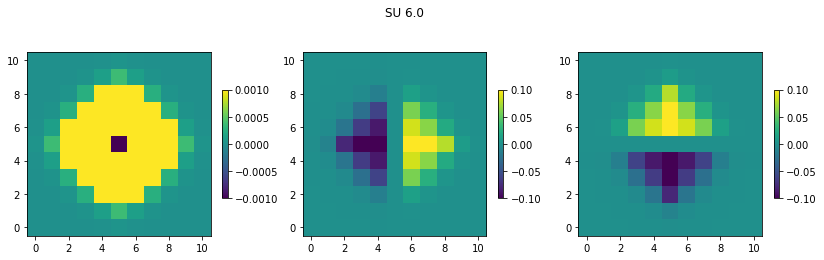

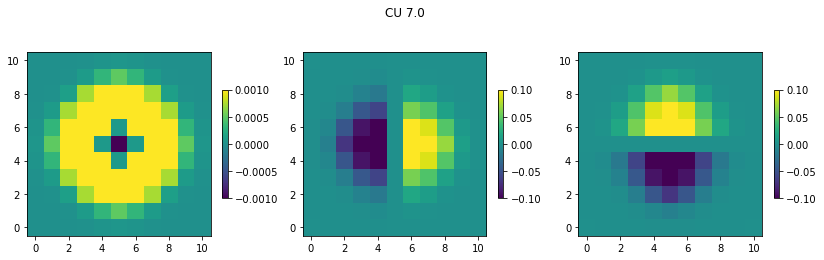

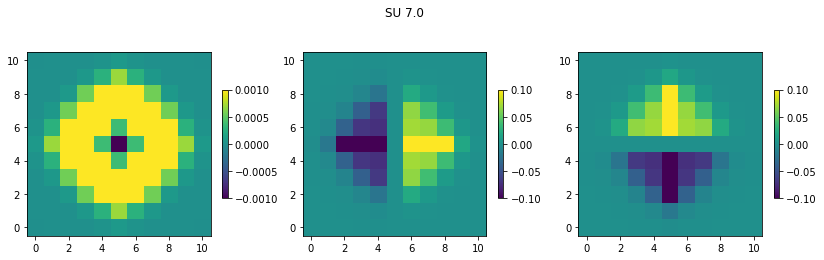

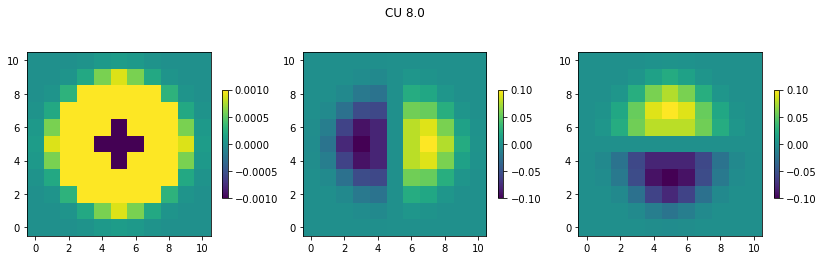

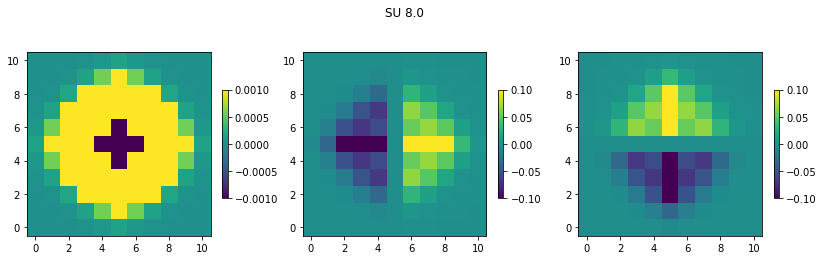

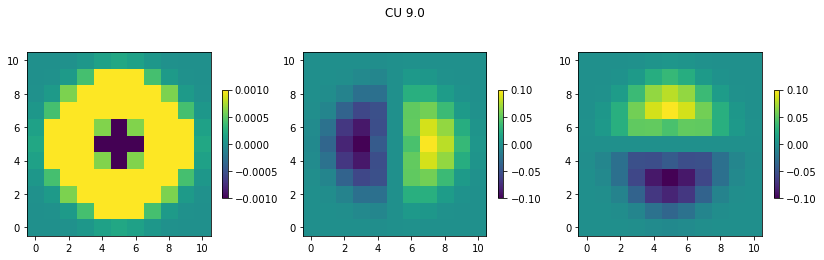

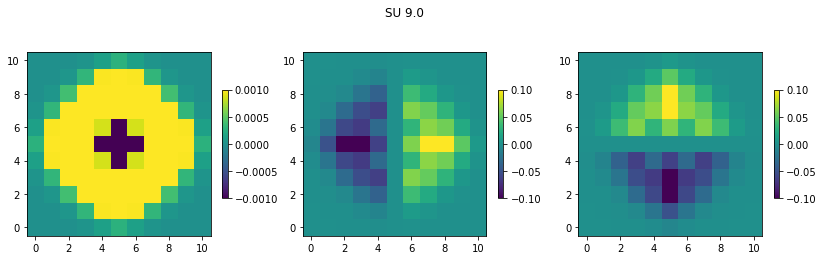

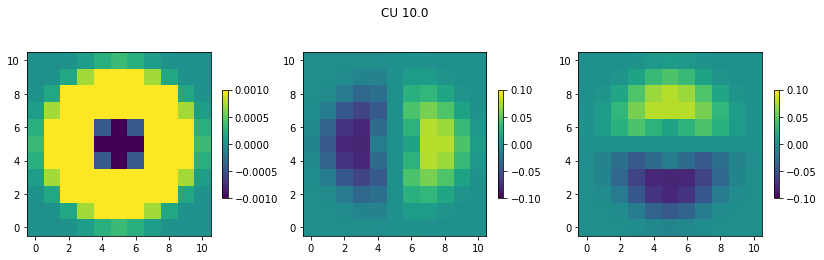

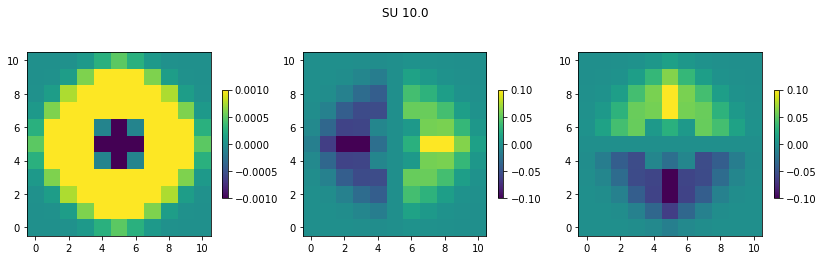

In [145]:
sim_cu.step(5*dt)
sim_su.step(5*dt)
for i in range(5):
    sim_cu.step(dt)
    cu_eta, cu_hu, cu_hv = sim_cu.download(interior_domain_only=True)
    plotstate(cu_eta[midy-5:midy+6,midx-5:midx+6], 
              cu_hu[ midy-5:midy+6,midx-5:midx+6], 
              cu_hv[ midy-5:midy+6,midx-5:midx+6], 
              "CU "+str(sim_cu.t), vmax=0.1)
    
    sim_su.step(dt)
    su_eta, su_hu, su_hv = sim_su.download(interior_domain_only=True)
    plotstate(su_eta[midy-5:midy+6,midx-5:midx+6], 
              su_hu[ midy-5:midy+6,midx-5:midx+6], 
              su_hv[ midy-5:midy+6,midx-5:midx+6], 
              "SU "+str(sim_su.t), vmax=0.1)
    
    #plotstate(su_eta[midy-5:midy+6,midx-5:midx+6] - cu_eta[midy-5:midy+6,midx-5:midx+6], 
    #          su_hu[ midy-5:midy+6,midx-5:midx+6] - cu_hu[ midy-5:midy+6,midx-5:midx+6], 
    #          su_hv[ midy-5:midy+6,midx-5:midx+6] - cu_hv[ midy-5:midy+6,midx-5:midx+6], 
    #          "DIFF "+str(sim_su.t), vmax=0.1)
    #plotstate(eta, hu, hv, "")


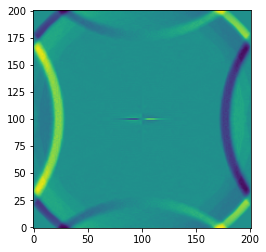

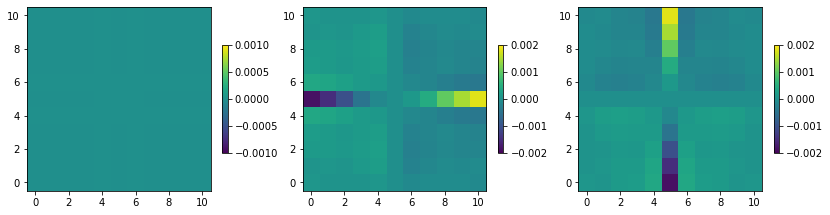

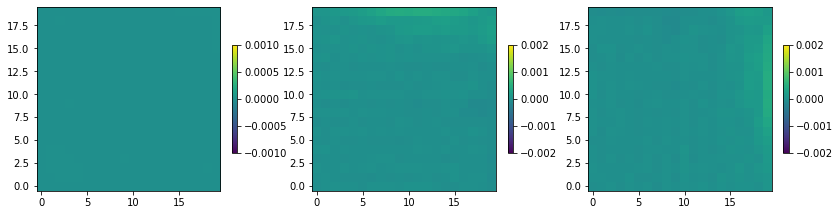

In [146]:
sim_su = CDKLM16.CDKLM16(**fvm_args, **sim_args, 
                          central_upwind=False, flux_delimiter=1.0, rk_order= 2)

sim_su.step(500)
eta, hu, hv = sim_su.download(interior_domain_only=True)
plt.imshow(hu, origin="lower")

plotstate(eta[midy-5:midy+6,midx-5:midx+6], 
            hu[ midy-5:midy+6,midx-5:midx+6], 
            hv[ midy-5:midy+6,midx-5:midx+6], "", vmax=2e-3)

plotstate(eta[ midy-20:midy,midx-20:midx], 
           hu[ midy-20:midy,midx-20:midx], 
           hv[ midy-20:midy,midx-20:midx], "", vmax=2e-3)

In [147]:
# Total variation


print(TV(sim_cu))
print(TV(sim_su))

T = 300
sim_cu = CDKLM16.CDKLM16(**fvm_args, **sim_args, 
                          central_upwind=False, flux_delimiter=0.0, rk_order= 2)
sim_su = CDKLM16.CDKLM16(**fvm_args, **sim_args, 
                          central_upwind=False, flux_delimiter=1.0, rk_order= 2)

tv_cu = np.zeros((3, T+1))
tv_su = np.zeros((3, T+1))
tv_cu[:,0] = TV(sim_cu)
tv_su[:,0] = TV(sim_su)
for i in range(T):
    sim_cu.step(dt)
    tv_cu[:,i+1] = TV(sim_cu)
    sim_su.step(dt)
    tv_su[:,i+1] = TV(sim_su)

(18.771427, 289.76697, 289.76697)
(17.096209, 376.19843, 376.19843)


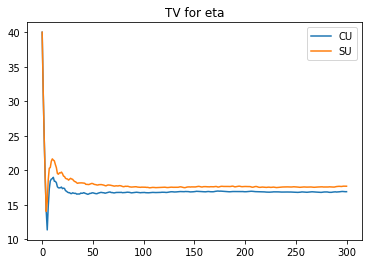

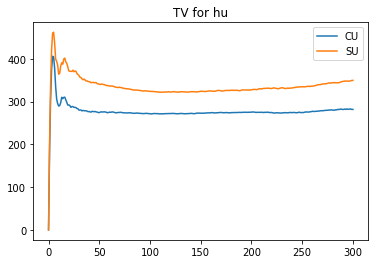

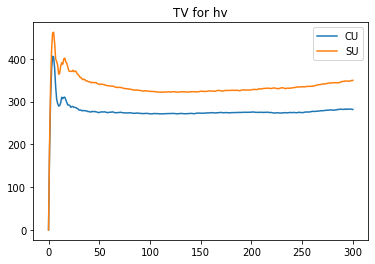

In [148]:
title=["eta", "hu", "hv"]
for i in range(3):
    plt.figure()
    plt.plot(tv_cu[i,:], label='CU')
    plt.plot(tv_su[i,:], label='SU')
    plt.legend()
    plt.title("TV for "+title[i])



